In [41]:
import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import csv

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2
%matplotlib inline

from helpers import calculate_mse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 0.1 Load and prepare data

### Training and testing data

#### Load the Data
`ratings` is a sparse matrix in the shape of (num_items, num_users)

In [42]:
from helpers import load_data, preprocess_data

DATA_PATH = '../data/'
PREDICTION_PATH = '../data/predictions/'
ratings = load_data('{dp}data_train.csv'.format(dp=DATA_PATH))
#ratings = load_data('{dp}movielens100k.csv'.format(dp=DATA_PATH))

number of items: 10000, number of users: 1000


#### Plot the number of ratings per movie and user

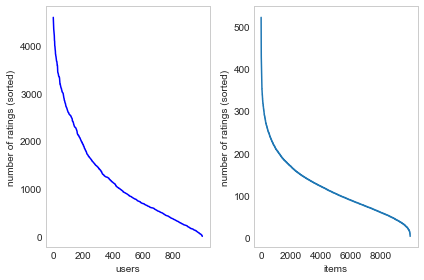

min # of items per user = 8, min # of users per item = 3.


In [43]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

#### Split the data into a train and test set

In [44]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1, verbose=False):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][:, valid_users]
    
    # LIL is a convenient format for constructing sparse matrices
    train = sp.lil_matrix(valid_ratings.shape)
    test = sp.lil_matrix(valid_ratings.shape)
    
    valid_ratings_i, valid_ratings_u, valid_ratings_v = sp.find(valid_ratings)
    valid_ratings_p_idx = np.random.permutation(range(len(valid_ratings_i)))
    
    n_test = int(p_test*len(valid_ratings_i))
    
    for idx in valid_ratings_p_idx[:n_test]:
        test[valid_ratings_i[idx], valid_ratings_u[idx]] = valid_ratings_v[idx]
        
    for idx in valid_ratings_p_idx[n_test:]:
        train[valid_ratings_i[idx], valid_ratings_u[idx]] = valid_ratings_v[idx]

    if verbose:
        print("Total number of nonzero elements in original data:{v}".format(v=ratings.nnz))
        print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
        print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    
    # convert to CSR for faster operations
    return valid_ratings, train.tocsr(), test.tocsr()

In [66]:
valid_ratings, train, test = split_data(ratings, num_items_per_user,
    num_users_per_item, min_num_ratings=10, p_test=0.1, verbose=True)

Total number of nonzero elements in original data:1176952
Total number of nonzero elements in train data:1059186
Total number of nonzero elements in test data:117687


### Read submission creation data

In [67]:
ratings_csr = ratings.tocsr()
sample_submission = load_data('{dp}sample_submission.csv'.format(dp=DATA_PATH))
sample_submission_csr = sample_submission.tocsr()

number of items: 10000, number of users: 1000


# 0.2 Auxiliary functions

In [68]:
def compute_division(a, b):
    """Computes element by element division.
    If x/0 returns 0.
    """
    # Raises error if vectors have different lengths
    assert(len(a) == len(b))
    
    # Computes division
    res = a.copy()
    for i in range(len(a)):
        if b[i] == 0:
            res[i] = 0
        else:
            res[i] = a[i] / b[i]

    return res

# 1 Baselines

In [69]:
# Baseline rating
def baseline_rating(data):
    """Implements baseline method for a ratings matrix
    using the global mean.
    """
    # Compute global mean using training data
    r_mean = data.sum() / data.getnnz()
    return r_mean


# User or item specific effect
def baseline_user_item_specific(data, mean, set_num=0):
    """Implements baseline method for a ratings matrix
    using either the user or the item mean,
    as indicated in parameter mean.
    """
    if mean=="user":
        flag = 1
        inv_flag = 0
    else:
        flag = 0
        inv_flag = 1

    num = max(set_num, data.shape[flag])
    
    # Obtain r_demeaned (ratings minus global avg)
    global_mean = baseline_rating(data)
    r_demeaned = data.copy()
    r_demeaned.data = (1.0 * r_demeaned.data) - global_mean
    
    # Compute means using training data
    # get rows, columns and values for elements in r_demeaned
    data_rcv = sp.find(r_demeaned)
    # compute means
    counts = np.bincount(data_rcv[flag], minlength=num)
    sums = np.bincount(data_rcv[flag], weights=data_rcv[2], minlength=num)
    means = compute_division(sums, counts)

    return means

In [70]:
def demean_matrix(data, verbose=False):
    """Removes the global, user and item means from a matrix.
    Returns the matrix and the computed means.
    """
    num_rows, num_cols = data.shape
    (rows, cols, vals) = sp.find(data)
    
    # Compute global, user and item means    
    global_mean = baseline_rating(data)
    item_means = baseline_user_item_specific(data, 'item')
    user_means = baseline_user_item_specific(data, 'user')
    
    # Substract the baseline of each element in 'data'
    train_vals = vals.copy()
    train_vals = 1.0 * train_vals
    
    baselines = np.array([(global_mean + item_means[i] + user_means[u])
        for (i, u) in zip(rows, cols)])
    train_vals = train_vals - baselines
    
    # Get matrix
    r_demeaned = sp.csr_matrix((train_vals, (rows, cols)),
        shape=(num_rows, num_cols))
    
    if verbose:
        print('---------------------------------------------')
        print('          Completed demean_matrix!           ')
        print('---------------------------------------------')
    
    return r_demeaned, global_mean, user_means, item_means

In [71]:
def demean_test_matrix(data, global_mean, item_means, user_means,
    verbose=False):
    """Removes the global, user and item means from a matrix.
    Returns the matrix and the computed means.
    """
    num_items, num_users = data.shape
    (rows, cols, vals) = sp.find(data)
    
    # Substract the baseline of each element in 'data'
    train_vals = vals.copy()
    train_vals = 1.0 * train_vals
    
    baselines = np.array([(global_mean + item_means[i] + user_means[u])
        for (i, u) in zip(rows, cols)])
    train_vals -= baselines

    # Get matrix
    r_demeaned = sp.csr_matrix((train_vals, (rows, cols)),
        shape=(num_items, num_users))
    
    if verbose:
        print('---------------------------------------------')
        print('          Completed demean_matrix!           ')
        print('---------------------------------------------')
    return r_demeaned

# 2 Matrix Factorization

In [72]:
def init_MF(data, k):
    """Initializes parameters for Matrix Factorization.
    Assumes 'data' matrix is already demeaned.
    """      
    np.random.seed(988)
    num_items, num_users = data.shape
    u_features = np.random.rand(k, num_users)
    i_features = np.random.rand(k, num_items)
    return u_features, i_features

In [73]:
def compute_error(data, u_features, i_features, nz):
    """Compute RMSE for prediction of nonzero elements."""
    preds = np.array([(u_features[:,u].dot(i_features[:,i]))
        for (i, u) in nz])
    vals = np.array([data[i,u] for (i,u) in nz])
    mse = calculate_mse(vals, preds)  
    rmse = np.sqrt(mse / len(vals))
    return rmse

Test these two functions:

In [74]:
def update_user_features(train, i_features, lambda_u,
    n_i_per_user, nz_i_per_user):
    """Updates user feature matrix."""
    n_u = len(nz_i_per_user)
    k = i_features.shape[0]
    lambda_u_I = lambda_u * sp.eye(k)
    new_u_features = np.zeros((k, n_u))
    for u, i in nz_i_per_user:
        M = i_features[:,i]
        V = train[i,u].T.dot(M.T)
        A = M.dot(M.T) + n_i_per_user[u] * lambda_u_I
        new_u_features[:,u] = np.linalg.solve(A, V.T).T
    return new_u_features

In [75]:
def update_item_features(train, u_features, lambda_i,
    n_u_per_item, nz_u_per_item):
    """Updates item feature matrix."""
    n_i = len(nz_u_per_item)
    k = u_features.shape[0]
    lambda_i_I = lambda_i * sp.eye(k)
    new_i_features = np.zeros((k, n_i))
    for i, u in nz_u_per_item:
        M = u_features[:,u]
        V = train[i,u].dot(M.T)
        A = M.dot(M.T) + n_u_per_item[i] * lambda_i_I
        new_i_features[:,i] = np.linalg.solve(A, V.T).T
    return new_i_features

In [76]:
from helpers import build_index_groups

In [121]:
def matrix_factorization_ALS(data_demeaned, test_demeaned, 
    k=20, lambda_u=.1, lambda_i=.7, tol=1e-4, max_iter=50,
    init_u_features=None, init_i_features=None):
    """Matrix factorization by ALS"""
    assert k <= min(data_demeaned.shape), "k must be smaller than the min dimension of 'data'"
    
    # Get non-zero elements
    (rows, cols, vals) = sp.find(data_demeaned)
    (test_rows, test_cols, test_vals) = sp.find(test_demeaned)

    # Set seed
    np.random.seed(988)
    
    # Initialize feature vectors for users and items
    rand_u_features, rand_i_features = init_MF(data_demeaned, k)
    if init_u_features is None:
        u_features = rand_u_features
    else:
        u_features = init_u_features

    if init_i_features is None:
        i_features = rand_i_features
    else:
        i_features = init_i_features

    # Get number of non-zero ratings per user and item
    n_i_per_user = data_demeaned.getnnz(axis=0)
    n_u_per_item = data_demeaned.getnnz(axis=1)
    
    # Get non-zero ratings per user and item
    nz_train, nz_u_per_item, nz_i_per_user = build_index_groups(data_demeaned)

    e = 1000
    
    # ALS-WR algorithm
    for it in range(max_iter):
        u_features = update_user_features(data_demeaned, i_features, lambda_u,
            n_i_per_user, nz_i_per_user)
        i_features = update_item_features(data_demeaned, u_features, lambda_i,
            n_u_per_item, nz_u_per_item)
        # compute and print new training error
        old_e = e
        e = compute_error(data_demeaned, u_features, i_features, nz_train)
        print("training RMSE: {}.".format(e))
        if(abs(old_e - e) < tol):
            print('Finished estimating features')
            break
        if(old_e - e < -tol):
            print('Whoops!')
            break
    # Do predictions        
    baselines = np.array([(global_mean + item_means[i] + user_means[u])
        for (i, u) in zip(test_rows, test_cols)])
    interactions = np.array([u_features[:,u].dot(i_features[:,i].T)
        for (i, u) in zip(test_rows, test_cols)])
    pred_test = baselines + interactions

    # Compute and print test error
    nnz_row, nnz_col = test.nonzero()
    nnz_test = list(zip(nnz_row, nnz_col))
    rmse = compute_error(test_demeaned, u_features, i_features, nnz_test)
    print("test RMSE after running ALS: {v}.".format(v=rmse))

    return u_features, i_features

tests

In [78]:
# Demean matrix and get feature vectors
r_demeaned, global_mean, user_means, item_means = demean_matrix(train, verbose=False)
test_r_demeaned = demean_test_matrix(test, global_mean, item_means,
    user_means, verbose=False)

In [79]:
u_features_0, i_features_0 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=0, lambda_i=0)

training RMSE: 0.8777862258178835.
training RMSE: 0.8609852732733557.
training RMSE: 0.8494242541625361.
training RMSE: 0.8414352305467109.
training RMSE: 0.8355475624432326.
training RMSE: 0.8309952836855966.
training RMSE: 0.8273675851466326.
training RMSE: 0.8244777626958406.
training RMSE: 0.8221390154538166.
training RMSE: 0.8202211401359562.
training RMSE: 0.8185933833674747.
training RMSE: 0.8172179375038617.
training RMSE: 0.8160185127237288.
training RMSE: 0.8149958845960243.
training RMSE: 0.8140796074315819.
training RMSE: 0.813272852105327.
training RMSE: 0.8125509141310915.
training RMSE: 0.8119033624186827.
training RMSE: 0.811321271454323.
training RMSE: 0.8107961328573489.
training RMSE: 0.8103140591436243.
training RMSE: 0.8098739035279681.
training RMSE: 0.8094649221133756.
training RMSE: 0.8090866257653035.
training RMSE: 0.808732652574688.
training RMSE: 0.808408715765256.
training RMSE: 0.8081055632920267.
training RMSE: 0.8078251981609506.
training RMSE: 0.8075565

In [81]:
u_features_1, i_features_1 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=0, lambda_i=0, init_u_features=u_features_0,
    init_i_features=i_features_0)

training RMSE: 0.8040678715167391.
training RMSE: 0.8039719579781739.
Finished estimating features
test RMSE after running ALS: 15.542746325402772.


In [100]:
u_features_003, i_features_003 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.03, lambda_i=.03, init_u_features=u_features_1,
    init_i_features=i_features_1)

training RMSE: 0.9237322846626974.
training RMSE: 0.8377009792170633.
training RMSE: 0.8294620803704968.
training RMSE: 0.8268916018781186.
training RMSE: 0.8256684789034854.
training RMSE: 0.8249008040169914.
training RMSE: 0.8243289815749132.
training RMSE: 0.8238632685956975.
training RMSE: 0.8234666760808166.
training RMSE: 0.8231206627287084.
training RMSE: 0.8228140956003854.
training RMSE: 0.8225393928546721.
training RMSE: 0.8222910263880261.
training RMSE: 0.8220648361798045.
training RMSE: 0.82185764338269.
training RMSE: 0.8216669915377129.
training RMSE: 0.8214909578679074.
training RMSE: 0.8213280120437985.
training RMSE: 0.8211769105248491.
training RMSE: 0.8210366180697286.
training RMSE: 0.820906249788166.
training RMSE: 0.8207850286920341.
training RMSE: 0.8206722551758153.
training RMSE: 0.8205672859272846.
training RMSE: 0.8204695203388169.
Finished estimating features
test RMSE after running ALS: 1.040108102927818.


In [97]:
u_features_005, i_features_005 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.05, lambda_i=.05, init_u_features=u_features_1,
    init_i_features=i_features_1)

training RMSE: 0.9440056863643365.
training RMSE: 0.8674954695546094.
training RMSE: 0.8527756072753845.
training RMSE: 0.8505934876576436.
training RMSE: 0.8494880935771318.
training RMSE: 0.848720736941489.
training RMSE: 0.8481214730423818.
training RMSE: 0.8476289975565953.
training RMSE: 0.8472131159422965.
training RMSE: 0.8468558521185766.
training RMSE: 0.8465452059838438.
training RMSE: 0.8462725930422873.
training RMSE: 0.84603159727241.
training RMSE: 0.8458172731311977.
training RMSE: 0.8456257147323165.
training RMSE: 0.8454537725199528.
training RMSE: 0.8452988593418155.
training RMSE: 0.8451588147997082.
training RMSE: 0.8450318094823973.
training RMSE: 0.8449162768709559.
training RMSE: 0.8448108642218617.
training RMSE: 0.8447143962935917.
Finished estimating features
test RMSE after running ALS: 1.0080531665669978.


In [98]:
u_features_005b, i_features_005b = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.05, lambda_i=.1, init_u_features=u_features_1,
    init_i_features=i_features_1)

training RMSE: 0.9641700419931245.
training RMSE: 0.9099997469053797.
training RMSE: 0.8887662061230855.
training RMSE: 0.8818756783694464.
training RMSE: 0.88007661343303.
training RMSE: 0.8791076687083005.
training RMSE: 0.8784200166669982.
training RMSE: 0.8778861494602218.
training RMSE: 0.8774535573502504.
training RMSE: 0.8770941181734742.
training RMSE: 0.8767904125917425.
training RMSE: 0.8765305723990653.
training RMSE: 0.8763059833829042.
training RMSE: 0.876110130288836.
training RMSE: 0.8759379524566021.
training RMSE: 0.8757854497925661.
training RMSE: 0.875649422955707.
training RMSE: 0.8755272919783184.
training RMSE: 0.8754169642133055.
training RMSE: 0.8753167350773614.
training RMSE: 0.8752252115252053.
Finished estimating features
test RMSE after running ALS: 0.9924255556022445.


In [99]:
u_features_005c, i_features_005c = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.1, lambda_i=.05, init_u_features=u_features_1,
    init_i_features=i_features_1)

training RMSE: 0.9471055893681931.
training RMSE: 0.9017959436917476.
training RMSE: 0.8862266980295657.
training RMSE: 0.8813930763595111.
training RMSE: 0.8799239460953054.
training RMSE: 0.8790337780995346.
training RMSE: 0.8783794213359105.
training RMSE: 0.8778634555244905.
training RMSE: 0.8774416351894632.
training RMSE: 0.8770891129131911.
training RMSE: 0.8767900401426214.
training RMSE: 0.8765333996259413.
training RMSE: 0.8763110782001142.
training RMSE: 0.8761168723659957.
training RMSE: 0.8759459220944804.
training RMSE: 0.8757943586665514.
training RMSE: 0.8756590691103389.
training RMSE: 0.8755375297766786.
training RMSE: 0.8754276839723851.
training RMSE: 0.8753278492149178.
Finished estimating features
test RMSE after running ALS: 0.9924443605327473.


In [109]:
u_features_01_part, i_features_01_part = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.08, lambda_i=.08, init_u_features=u_features_1,
    init_i_features=i_features_1, max_iter=70)

training RMSE: 0.9600277350424331.
training RMSE: 0.9222327630355288.
training RMSE: 0.9048966995498046.
training RMSE: 0.8975922966242754.
training RMSE: 0.8952037310593314.
training RMSE: 0.8941106937455304.
training RMSE: 0.893386142533172.
training RMSE: 0.8928393495253608.
training RMSE: 0.8924038884398758.
training RMSE: 0.8920466804840125.
training RMSE: 0.8917479838686498.
training RMSE: 0.8914946655055959.
training RMSE: 0.8912773492931217.
training RMSE: 0.891089029117208.
training RMSE: 0.8909243170385202.
training RMSE: 0.8907789945585042.
training RMSE: 0.8906497215479667.
training RMSE: 0.8905338345742426.
training RMSE: 0.8904292002274201.
training RMSE: 0.8903341046975557.
Finished estimating features
test RMSE after running ALS: 0.9891936059402625.


In [82]:
u_features_01, i_features_01 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.1, lambda_i=.1, init_u_features=u_features_1,
    init_i_features=i_features_1)

training RMSE: 0.9664856383101701.
training RMSE: 0.9518009394617436.
training RMSE: 0.940508321560623.
training RMSE: 0.9344077573489507.
training RMSE: 0.9309489496193133.
training RMSE: 0.9289890089113081.
training RMSE: 0.9278356364443863.
training RMSE: 0.9270917039056633.
training RMSE: 0.9265632906094825.
training RMSE: 0.9261607690961122.
training RMSE: 0.9258402188232969.
training RMSE: 0.925577535108613.
training RMSE: 0.9253579018294267.
training RMSE: 0.9251713785840238.
training RMSE: 0.925010887685777.
training RMSE: 0.9248711931764648.
training RMSE: 0.9247483248361132.
training RMSE: 0.9246392221248814.
training RMSE: 0.9245414982261824.
Finished estimating features
test RMSE after running ALS: 0.987794646682212.


In [133]:
u_features_01, i_features_01 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.1, lambda_i=.11, init_u_features=u_features_1,
    init_i_features=i_features_1, tol=1e-6)

training RMSE: 0.9685997756660341.
training RMSE: 0.9579673096160713.
training RMSE: 0.9483720642486728.
training RMSE: 0.9429259898308623.
training RMSE: 0.9397650530051787.
training RMSE: 0.9378346905308949.
training RMSE: 0.936598493760148.
training RMSE: 0.9357690859666724.
training RMSE: 0.9351813018252785.
training RMSE: 0.9347416198590953.
training RMSE: 0.9343980199865941.
training RMSE: 0.9341207075531481.
training RMSE: 0.9338915344316967.
training RMSE: 0.9336986709744584.
training RMSE: 0.9335339451350378.
training RMSE: 0.933391459874835.
training RMSE: 0.933266826567983.
training RMSE: 0.933156707949649.
training RMSE: 0.9330585267874412.
training RMSE: 0.9329702698626089.
training RMSE: 0.9328903505724515.
training RMSE: 0.9328175096246134.
training RMSE: 0.9327507415365298.
training RMSE: 0.9326892391761074.
training RMSE: 0.9326323512388698.
training RMSE: 0.9325795492082329.
training RMSE: 0.9325304014114097.
training RMSE: 0.9324845524889898.
training RMSE: 0.9324417

In [94]:
u_features_02, i_features_02 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.1, lambda_i=.2, init_u_features=u_features_01,
    init_i_features=i_features_01)

training RMSE: 0.9506675376578096.
training RMSE: 0.9670304223697375.
Whoops!
test RMSE after running ALS: 0.9954312095537533.


In [96]:
u_features_02, i_features_02 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.1, lambda_i=.2, init_u_features=u_features_1,
    init_i_features=i_features_1, tol=1e-6, max_iter=15)

training RMSE: 0.9791089571509457.
training RMSE: 0.9841546392393206.
Whoops!
test RMSE after running ALS: 1.0026210568848657.


In [102]:
u_features_0_40, i_features_0_40 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=0, lambda_i=0, k=40, max_iter=70)

training RMSE: 0.764079693732386.
training RMSE: 0.7487370440355664.
training RMSE: 0.7367960202706672.
training RMSE: 0.7277611007095072.
training RMSE: 0.7208526966769482.
training RMSE: 0.7154968417729765.
training RMSE: 0.7111754166452892.
training RMSE: 0.7076865431408613.
training RMSE: 0.704699234689281.
training RMSE: 0.7021060690878047.
training RMSE: 0.6998590462945328.
training RMSE: 0.6979209453377244.
training RMSE: 0.6961410618500861.
training RMSE: 0.694559626538089.
training RMSE: 0.6930833050041255.
training RMSE: 0.6917270187892332.
training RMSE: 0.6904966214487582.
training RMSE: 0.6893671279734188.
training RMSE: 0.6883076483311295.
training RMSE: 0.6873107339225871.
training RMSE: 0.6863843093995506.
training RMSE: 0.685512344385891.
training RMSE: 0.6846845872536762.
training RMSE: 0.6838871751026376.
training RMSE: 0.6831354320210377.
training RMSE: 0.6824119004878529.
training RMSE: 0.6817422747511901.
training RMSE: 0.6810785577330692.
training RMSE: 0.6804515

In [103]:
u_features_01_40, i_features_01_40 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.1, lambda_i=.1, init_u_features=u_features_0_40,
    init_i_features=i_features_0_40, max_iter=70)

training RMSE: 0.9502352027002542.
training RMSE: 0.9442463019939583.
training RMSE: 0.9317874269516543.
training RMSE: 0.9240640706412115.
training RMSE: 0.9191567410712959.
training RMSE: 0.915690869857496.
training RMSE: 0.9131276180328665.
training RMSE: 0.9111635865378096.
training RMSE: 0.909617128227158.
training RMSE: 0.9083764596865558.
training RMSE: 0.9073694332858585.
training RMSE: 0.9065461682002757.
training RMSE: 0.905869340049313.
training RMSE: 0.9053093996256297.
training RMSE: 0.9048425801177487.
training RMSE: 0.9044499832850232.
training RMSE: 0.904116844496979.
training RMSE: 0.9038317577078886.
training RMSE: 0.903585925110162.
training RMSE: 0.9033725164600377.
training RMSE: 0.9031861686892968.
training RMSE: 0.9030226147108737.
training RMSE: 0.9028784143793848.
training RMSE: 0.9027507602676852.
training RMSE: 0.9026373363786178.
training RMSE: 0.9025362139785529.
training RMSE: 0.9024457736207165.
Finished estimating features
test RMSE after running ALS: 0.

In [111]:
u_features_01_40, i_features_01_40 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.1, lambda_i=.1, init_u_features=u_features_01_40,
    init_i_features=i_features_01_40, max_iter=70)

training RMSE: 0.902364645889504.
training RMSE: 0.9022916657271381.
Finished estimating features
test RMSE after running ALS: 0.9881990898640572.


In [122]:
u_features_011_40, i_features_011_40 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.1, lambda_i=.12, init_u_features=u_features_01_40,
    init_i_features=i_features_01_40, max_iter=100)

training RMSE: 0.9128528648114087.
training RMSE: 0.9210937166399196.
Whoops!
test RMSE after running ALS: 0.9894435954115074.


In [123]:
u_features_011_40, i_features_011_40 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.09, lambda_i=.12, init_u_features=u_features_01_40,
    init_i_features=i_features_01_40, max_iter=100)

training RMSE: 0.9038697832853849.
training RMSE: 0.9092718046081801.
Whoops!
test RMSE after running ALS: 0.9886557944140847.


In [124]:
u_features_011_40, i_features_011_40 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.08, lambda_i=.12, init_u_features=u_features_01_40,
    init_i_features=i_features_01_40, max_iter=100)

training RMSE: 0.8933850328506282.
training RMSE: 0.8954467443980143.
Whoops!
test RMSE after running ALS: 0.9882084317023953.


In [130]:
u_features_011_40, i_features_011_40 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.07, lambda_i=.12, init_u_features=u_features_01_40,
    init_i_features=i_features_01_40, max_iter=100)

training RMSE: 0.8810657605174731.
training RMSE: 0.8793935512980934.
training RMSE: 0.8785809539198273.
training RMSE: 0.8781562734253077.
training RMSE: 0.8779093952847788.
training RMSE: 0.8777493039843631.
training RMSE: 0.877635216534865.
training RMSE: 0.8775477675807446.
Finished estimating features
test RMSE after running ALS: 0.9885774655054526.


In [132]:
u_features_011_40, i_features_011_40 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.075, lambda_i=.12, init_u_features=u_features_01_40,
    init_i_features=i_features_01_40, max_iter=100)

training RMSE: 0.8874785714241855.
training RMSE: 0.8877111475985815.
Whoops!
test RMSE after running ALS: 0.9881828339262694.


In [ ]:
u_features_011_40, i_features_011_40 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.07, lambda_i=.125, init_u_features=u_features_01_40,
    init_i_features=i_features_01_40, max_iter=100)

In [131]:
u_features_011_40, i_features_011_40 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.07, lambda_i=.11, init_u_features=u_features_01_40,
    init_i_features=i_features_01_40, max_iter=100)

training RMSE: 0.8750818340461232.
training RMSE: 0.8695922561249994.
training RMSE: 0.867707582231519.
training RMSE: 0.8669284630621088.
training RMSE: 0.8665385416222589.
training RMSE: 0.8663071990811342.
training RMSE: 0.8661504826331785.
training RMSE: 0.8660338957824613.
training RMSE: 0.8659415335224563.
Finished estimating features
test RMSE after running ALS: 0.9892708596057171.


In [ ]:
u_features_011_40, i_features_011_40 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.08, lambda_i=.11, init_u_features=u_features_01_40,
    init_i_features=i_features_01_40, max_iter=100, tol=1e-6)

In [128]:
u_features_011_40, i_features_011_40 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.09, lambda_i=.11, init_u_features=u_features_01_40,
    init_i_features=i_features_01_40, max_iter=100)

training RMSE: 0.8985616420449941.
training RMSE: 0.8999608562744604.
Whoops!
test RMSE after running ALS: 0.9882211047909539.


In [107]:
u_features_0_60, i_features_0_60 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=0, lambda_i=0, k=60, max_iter=100)

training RMSE: 0.6534586137476438.
training RMSE: 0.6422907295119796.
training RMSE: 0.6331741478288732.
training RMSE: 0.6256363782162372.
training RMSE: 0.6194738245373587.
training RMSE: 0.6143144050570912.
training RMSE: 0.6100458734836691.
training RMSE: 0.6064691141476916.
training RMSE: 0.6033600154625663.
training RMSE: 0.600653562124729.
training RMSE: 0.5982701005116559.
training RMSE: 0.5961304061334717.
training RMSE: 0.5942677051762565.
training RMSE: 0.5925809042310873.
training RMSE: 0.5910473468706384.
training RMSE: 0.589617763857291.
training RMSE: 0.5883066092943257.
training RMSE: 0.5871116203645589.
training RMSE: 0.5859757307322169.
training RMSE: 0.5849288592007581.
training RMSE: 0.5839240494548217.
training RMSE: 0.5829927950056296.
training RMSE: 0.5821408631750924.
training RMSE: 0.5813338361280506.
training RMSE: 0.5805419732371625.
training RMSE: 0.5797926055089133.
training RMSE: 0.579082452475022.
training RMSE: 0.5783974363822718.
training RMSE: 0.577757

In [127]:
u_features_02_60, i_features_02_60 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.04, lambda_i=.09, init_u_features=u_features_0_60,
    init_i_features=i_features_0_60, max_iter=100)

training RMSE: 0.9197684680709619.
training RMSE: 0.8291455686658581.
training RMSE: 0.7833544267088788.
training RMSE: 0.7651973293076858.
training RMSE: 0.7557495001054115.
training RMSE: 0.7498590990256256.
training RMSE: 0.7460607826657366.
training RMSE: 0.7433918339936172.
training RMSE: 0.741384133054206.
training RMSE: 0.739817099579396.
training RMSE: 0.7385638616161235.
training RMSE: 0.7375422613834153.
training RMSE: 0.7366959292507607.
training RMSE: 0.7359848981412597.
training RMSE: 0.7353801917791133.
training RMSE: 0.7348604224019104.
training RMSE: 0.7344095423182087.
training RMSE: 0.7340153156117378.
training RMSE: 0.7336682625625537.
training RMSE: 0.7333609227514835.
training RMSE: 0.7330873357602062.
training RMSE: 0.7328426715639716.
training RMSE: 0.7326229646833201.
training RMSE: 0.7324249209054203.
training RMSE: 0.7322457752369247.
training RMSE: 0.7320831863170385.
training RMSE: 0.7319351569362869.
training RMSE: 0.7317999733341011.
training RMSE: 0.73167

In [110]:
u_features_02_60, i_features_02_60 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.1, lambda_i=.1, init_u_features=u_features_0_60,
    init_i_features=i_features_0_60, max_iter=100)

training RMSE: 0.937124945573667.
training RMSE: 0.938213384019861.
Whoops!
test RMSE after running ALS: 1.0001283823013505.


In [108]:
u_features_02_60, i_features_02_60 = matrix_factorization_ALS(r_demeaned, test_r_demeaned,
    lambda_u=.2, lambda_i=.2, init_u_features=u_features_0_60,
    init_i_features=i_features_0_60, max_iter=70)

training RMSE: 0.9702491543325727.
training RMSE: 0.9918356528055405.
Whoops!
test RMSE after running ALS: 1.0052750914530304.
